## Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

In [7]:
product_data = pd.read_csv('Products.csv')
product_data.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [8]:
customer_data = pd.read_csv('Customers.csv')
customer_data.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [9]:
transaction_data = pd.read_csv('Transactions.csv')
transaction_data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [10]:
# Data Overview
print("Customers Data Info:")
print(customer_data.info())
print("\nProducts Data Info:")
print(product_data.info())
print("\nTransactions Data Info:")
print(transaction_data.info())

Customers Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Products Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
None

Transactions Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    

In [11]:
customer_data.isnull().sum()

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

In [12]:
product_data.isnull().sum()

ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

In [13]:
transaction_data.isnull().sum()

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

In [14]:
# Check for duplicates
print("\nDuplicate Records:")
print(f"Customers: {customer_data.duplicated().sum()}, Products: {product_data.duplicated().sum()}, Transactions: {transaction_data.duplicated().sum()}")



Duplicate Records:
Customers: 0, Products: 0, Transactions: 0


In [15]:
# Summary statistics
print("\nSummary Statistics - Transactions:")
print(transaction_data.describe())


Summary Statistics - Transactions:
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


In [16]:
# Merge datasets for deeper analysis
df = transaction_data.merge(customer_data, on='CustomerID').merge(product_data, on='ProductID')
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [38]:
# Customer Segmentation / Clustering
# Aggregate transaction data for clustering
customer_spending = df.groupby('CustomerID').agg({'TotalValue': 'sum', 'Quantity': 'sum'}).reset_index()
customer_data = customer_data.merge(customer_spending, on='CustomerID', how='left').fillna(0)

In [24]:
customer_data

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7.0
...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,4982.88,12.0
196,C0197,Christina Harvey,Europe,2023-03-21,1928.65,9.0
197,C0198,Rebecca Ray,Europe,2022-02-27,931.83,3.0
198,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,9.0


In [25]:
# Normalize data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['TotalValue', 'Quantity']])

In [32]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Define clustering methods
clustering_methods = {
    "K-Means": KMeans(n_clusters=5, random_state=42, n_init=10),
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=5),
    "Gaussian Mixture": GaussianMixture(n_components=5, random_state=42)
}

# Store DB Index and Silhouette Scores
results = []

for method_name, model in clustering_methods.items():
    if method_name == "Gaussian Mixture":
        # Gaussian Mixture needs predict instead of fit_predict
        labels = model.fit(scaled_data).predict(scaled_data)
    else:
        labels = model.fit_predict(scaled_data)
    
    # Calculate DB Index
    db_index = davies_bouldin_score(scaled_data, labels)
    
    # Calculate Silhouette Score for better clustering evaluation
    silhouette_avg = silhouette_score(scaled_data, labels)
    
    # Save the results
    results.append((method_name, db_index, silhouette_avg))

# Print the results
print(f"{'Method':<25}{'DB Index':<15}{'Silhouette Score':<15}")
print("-" * 50)
for method_name, db_index, silhouette_avg in results:
    print(f"{method_name:<25}{db_index:<15.4f}{silhouette_avg:<15.4f}")


Method                   DB Index       Silhouette Score
--------------------------------------------------
K-Means                  0.7529         0.4315         
Agglomerative Clustering 0.7569         0.4237         
Gaussian Mixture         0.7892         0.4151         


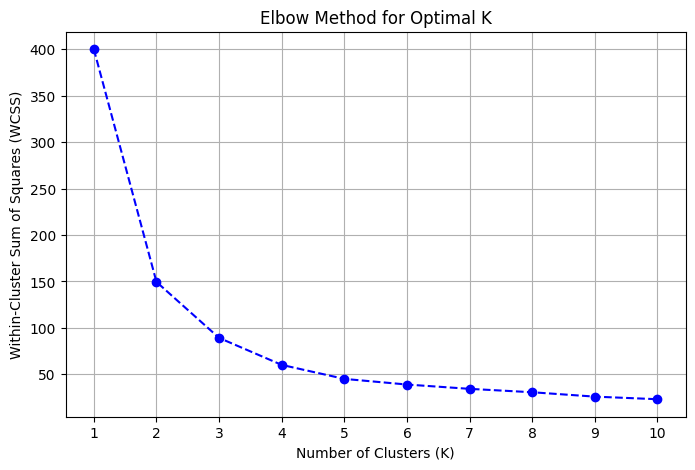

In [33]:
wcss = []

# Test K values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the WCSS values
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid()
plt.show()


In [29]:
# Apply K-Means clustering
num_clusters = 3  # Can be adjusted
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

In [30]:
# Evaluate clustering with DB Index
db_index = davies_bouldin_score(scaled_data, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.4f}")

Davies-Bouldin Index: 0.6862


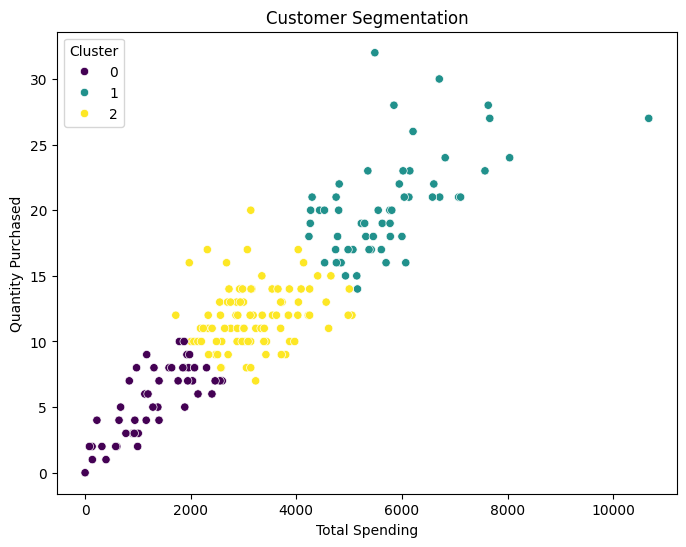

In [31]:
# Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_data['TotalValue'], y=customer_data['Quantity'], hue=customer_data['Cluster'], palette='viridis')
plt.xlabel('Total Spending')
plt.ylabel('Quantity Purchased')
plt.title('Customer Segmentation')
plt.legend(title='Cluster')
plt.show()

In [34]:
# Apply K-Means clustering
num_clusters = 4 # Can be adjusted
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

In [35]:
# Evaluate clustering with DB Index
db_index = davies_bouldin_score(scaled_data, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.4f}")

Davies-Bouldin Index: 0.7103


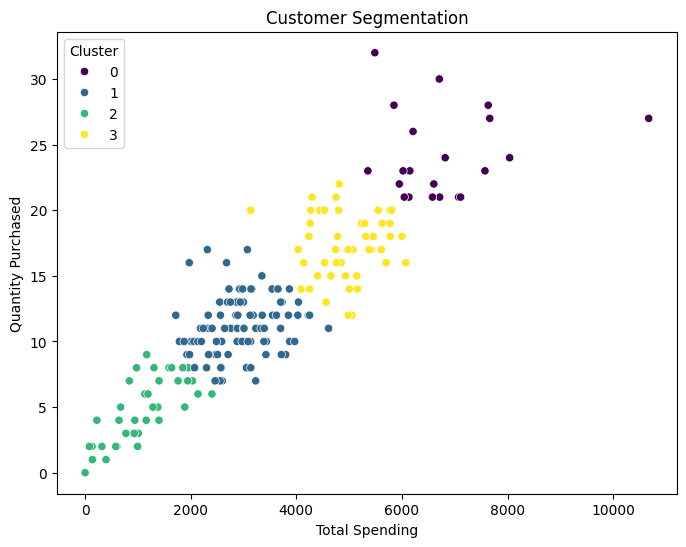

In [36]:
# Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_data['TotalValue'], y=customer_data['Quantity'], hue=customer_data['Cluster'], palette='viridis')
plt.xlabel('Total Spending')
plt.ylabel('Quantity Purchased')
plt.title('Customer Segmentation')
plt.legend(title='Cluster')
plt.show()

## K-Means with 3 clusters is better giving Davies-Bouldin Index: 0.6862 and  Silhouette Score of  0.4315